In [0]:
from simulator import Simulator, Map, Agent
from devices import Device 
import numpy as np 
from time import time 
from utils import dist 
import math

##an example of simulator configuration
class config:
    metadata = {
    'render.modes': ['human', 'rgb_array'],
    'video.frames_per_second': 10,
    'world_width': 300,
    'world_height': 250,
    'screen_width': 600, # size of window
    'screen_height': 500, # size of window
    'dt': 1.0 / 10, # update interval in the system
    'eps': 1.0 # minimal distance for collision detection
    }
    rebounce = 0.5 # rebounce factor. 0 for no rebounce. 1 for rebounce with same speed at the opposite direction.

#example of overloading agent class
class Robot(Agent): 
    def __init__(self, env,ID,target_ID,offset,master_point,a,b,h):
        '''
            for each subclass of Agent you need to implement update method to update the velocity or acceleration
            to enable motion.
        '''
        Agent.__init__(self, env, 
                       kp=np.array([[-2, -2], [2, -2], [2, 2], [-2, 2]]), 
                       color=(1, 0, 0, 0.5), 
                       v_max=2.0)
        self.sensor = Sensor(env, self)
        self.sensor = Sensor(env, self) 
        self.ID=ID 
        self.desire_pos=None 
        self.target_ID=target_ID ## list (1n) 
        self.target_pos=None ## list(n3) 
        self.current_pos=None## this pos should be added an offset later 
        self.cf_v=None 
        self.offset=offset 
        self.offset_pos=None 
        self.master_point=False## determine whether this is a communication node 
        self.a=a 
        self.b=b 
        self.h=h## act as offset between neighbors because its different from offset

        ## self.h is also a list with the same order of self.target_ID
        ## get_pos will return the real time pos everytime you call get_posdef get_pos(self):
    def update(self,desire_pos):# pos should be a numpy array
        self.sensor.read()
        self.get_cf_v(desire_pos)
        # the renderer           
        self.v = np.array(self.cf_v)
        return self.loc()
    def return_v(self):
        return self.v
    def get_pos(self):
        return self.loc()
    def get_target_pos(self):
        target_len=len(self.target_ID)
        pos_list=[]
        for i in range(target_len):
            cf_target=allrobot[self.target_ID[i]]
            t_pos=cf_target.get_pos()
            pos_list.append(t_pos)
        return pos_list
    def update_param(self,desire_pos):
        self.current_pos=self.get_pos()
        self.offset_pos=self.current_pos+self.offset
        self.target_pos=self.get_target_pos()
        self.desire_pos=desire_pos
    def get_cf_v(self,desire_pos):
        self.update_param(desire_pos)
        if not self.master_point:
            pos=self.current_pos
            result_offset=np.array(self.target_pos)-np.array(self.h)
            B_vector=0
            for i in range(len(result_offset)):
                B_vector=B_vector+normalize(self.target_pos[i]-self.current_pos-self.h[i])
            A_vector=(self.desire_pos-pos)
            self.cf_v=self.a*A_vector+self.b*B_vector## change cf_v here
        else:
            pos=self.current_pos
            A_vector=(self.desire_pos-pos)
            B_vector=0
            for i in range(len(result_offset)):
                B_vector=B_vector+normalize(self.target_pos[i]-self.current_pos-self.h[i])
            self.cf_v=self.a*A_vector+self.b*B_vector
#what is this self.va = np.pi
#example of a range sensor that changes color when detect other agents or a obstacle.
class Sensor(Device):
    def __init__(self, env, parent, radius=5):
        self.radius = radius
        kp=np.array([[-radius, 0], [radius, 0]])
        Device.__init__(self, env, parent, kp=kp, color=(0, 1, 0, 0.5), filled=True)

    def read(self):
        '''
        return true if detect something.
        '''
        for a in self.env.agents:
            if a is not self.parent:
                print(dist(self.parent, a))
            if (a is not self.parent) and dist(self.parent, a) < self.radius:
                self.geom.set_color_rgba(np.array([1, 0, 0, 0.5]))
                return True
        if dist(self.parent, self.env.map) < self.radius:
            self.geom.set_color_rgba(np.array([1, 0, 0, 0.5]))
            return True

            # no collision
        self.geom.set_color_rgba(np.array([0, 1, 0, 0.5]))
        return False
def sgn(v): 
    if np.linalg.norm(v)>0: 
        return v/np.linalg.norm(v) 
    if np.linalg.norm(v)==0: 
        return 0 
    if np.linalg.norm(v)<0: 
        return -v/np.linalg.norm(v)

    
def pos_calculator(my_pose,designated_pos):
    r=10
    n=my_pose[0]
    m=my_pose[1]
    p=designated_pos[0]
    q=designated_pos[1]
    A=(n-p)**2+m**2-2*m*q+q**2
    B=-2*p*((n-p)**2)-2*p*(m**2)+2*m*q*n+2*q*m*p-2*(q**2)*n-2*q*m*(n-p)+2*(q**2)*(n-p)
    C=(p**2+q**2-r)*((n-p)**2)+(p*m-q*n)**2+(2*p*m*q-2*(q**2)*n)*(n-p)
    x1=(-B+math.sqrt(B**2-4*A*C))/(2*A)
    x2=(-B-math.sqrt(B**2-4*A*C))/(2*A)
    y1=(x1*(m-p)-p*m+q*n)/(n-p)
    y2=(x2*(m-p)-p*m+q*n)/(n-p)
    if ((n-x1)**2+(m-y1)**2)<(((n-x1)**2+(m-y1)**2)):
        return np.array([x1,y1])
    else:
        return np.array([x2,y2])

## did not add vel ctrl 
def cal_Op_pos(DT,v_max,center,r,r_max):
    ## w = v/r
    a=center[0]-r*(math.sin((v_max/r_max)*DT))## vel ctrl need to be before DT
    b=center[1]+r*(math.cos((v_max/r_max)*DT))## circle point(100, -80)
    a=math.floor(a)## should be delete in real implementation
    b=math.floor(b)
    return np.array([a,b]) ## when it first begin, there should be no jump

def cal_Line(DT,num):
    a=DT*num
    b=DT*num
    a=math.floor(a)
    b=math.floor(b)
    return np.array([a,b])
    
    

def normalize(v): ## this normalize function needs further tests 
    norm=np.linalg.norm(v) 
    if norm>1: 
        return v/norm 
    return v

env = Simulator(config=config) 
my_map = Map() 
my_map.get_map_from_geom2d(env, kp=np.array([[-200, 200], [-200, -200], [200, -200], [200, 200]]))
## b is the factor for maintain formation
##def init(self, env,ID,target_ID,offset,master_point,a,b,h) 
robot_1 = Robot(env,1,[4,2],[0,0],True,1,50,[[0,-10],[10,0]]) 
robot_2 = Robot(env,2,[1,3],[-10,0],False,1,50,[[-10,0],[0,-10]]) 
robot_3 = Robot(env,3,[2],[-10,10],False,1,50,[[0,10]]) 
robot_4 = Robot(env,4,[1],[0,10],False,1,50,[[0,10]]) 
robot_1.reset(init_state=np.array([0,50,0])) 
robot_2.reset(init_state=np.array([50,50,0])) 
robot_3.reset(init_state=np.array([75,-75,0])) 
robot_4.reset(init_state=np.array([0,-50,0])) 
allrobot=[0,robot_1,robot_2,robot_3,robot_4]

Op_point_1=np.array([0,0])
Op_point_2=np.array([0,0])
Op_point_3=np.array([0,0])
Op_point_4=np.array([0,0])
pos1=np.array([0,50]) 
pos2=np.array([50,50]) 
pos3=np.array([75,-75]) 
pos4=np.array([0,-50])
t0=time()
r3=0.25*100
r2=0.75*100
r4=0.5*100
r1=1*100
while True:

    pos1=robot_1.update(desire_pos=Op_point_1)## set to pos 1listen to the master
    pos2=robot_2.update(desire_pos=Op_point_2)## but the master is really the middle
    pos3=robot_3.update(desire_pos=Op_point_3)
    pos4=robot_4.update(desire_pos=Op_point_4)
    env._render()
    DT=time()-t0
    Op_point_1=cal_Op_pos(DT,10,[0,0],r1,r1)
    Op_point_2=cal_Op_pos(DT,10,[0,0],r2,r1)
    Op_point_3=cal_Op_pos(DT,10,[0,0],r3,r1)
    Op_point_4=cal_Op_pos(DT,10,[0,0],r4,r1)
    

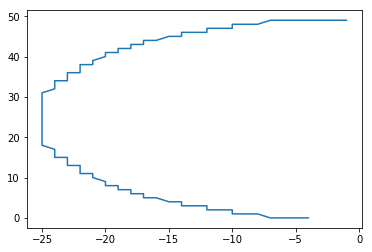

In [0]:
from matplotlib import pyplot as plt
from time import time
import math
import numpy as np


def cal_Op_pos(DT,v_max,center,r,r_max):
    ## w = v/r
    a=center[0]-r*(math.sin(10*(v_max/r_max)*DT))## vel ctrl need to be before DT
    b=center[1]+r*(math.cos(10*(v_max/r_max)*DT))## circle point(100, -80)
    a=math.floor(a)## should be delete in real implementation
    b=math.floor(b)
    return np.array([a,b]) ## when it first begin, there should be no jump

DT=0
t0=time()
r1=0.25*100
r2=0.75*100
r3=0.5*100
r4=1*100
point_x=[]
point_y=[]
while(DT<10):
    t1=time()
    DT=t1-t0
    [x,y]=cal_Op_pos(DT,3,[0,r1],r1,r4)
    point_x.append(x)
    point_y.append(y)
    
plt.plot(point_x,point_y)

In [0]:
Op_point_1=cal_Op_pos(DT,1.25)
    Op_point_2=cal_Op_pos(DT,3.75)
    Op_point_3=cal_Op_pos(DT,2.5)
    Op_point_4=cal_Op_pos(DT,0.625)
    Op_point_1=cal_Op_pos(DT,3,[0,0],r1,r1)
    Op_point_2=cal_Op_pos(DT,3,[0,0],r2,r1)
    Op_point_3=cal_Op_pos(DT,3,[0,0],r3,r1)
    Op_point_4=cal_Op_pos(DT,3,[0,0],r4,r1)

In [0]:
from simulator import Simulator, Map, Agent
from devices import Device 
import numpy as np 
from time import time 
from utils import dist 
import math

##an example of simulator configuration
class config:
    metadata = {
    'render.modes': ['human', 'rgb_array'],
    'video.frames_per_second': 10,
    'world_width': 300,
    'world_height': 250,
    'screen_width': 600, # size of window
    'screen_height': 500, # size of window
    'dt': 1.0 / 10, # update interval in the system
    'eps': 1.0 # minimal distance for collision detection
    }
    rebounce = 0.5 # rebounce factor. 0 for no rebounce. 1 for rebounce with same speed at the opposite direction.

#example of overloading agent class
class Robot(Agent): 
    def __init__(self, env,ID,target_ID,offset,master_point,a,b,h):
        '''
            for each subclass of Agent you need to implement update method to update the velocity or acceleration
            to enable motion.
        '''
        Agent.__init__(self, env, 
                       kp=np.array([[-2, -2], [2, -2], [2, 2], [-2, 2]]), 
                       color=(1, 0, 0, 0.5), 
                       v_max=2.0)
        self.sensor = Sensor(env, self)
        self.sensor = Sensor(env, self) 
        self.ID=ID 
        self.desire_pos=None 
        self.target_ID=target_ID ## list (1n) 
        self.target_pos=None ## list(n3) 
        self.current_pos=None## this pos should be added an offset later 
        self.cf_v=None 
        self.offset=offset 
        self.offset_pos=None 
        self.master_point=False## determine whether this is a communication node 
        self.a=a 
        self.b=b 
        self.h=h## act as offset between neighbors because its different from offset
        self.B_vector=None## for phi restriction

        ## self.h is also a list with the same order of self.target_ID
        ## get_pos will return the real time pos everytime you call get_posdef get_pos(self):
    def update(self,desire_pos):# pos should be a numpy array
        self.sensor.read()
        self.get_cf_v(desire_pos)
        ## the renderer
        ## add for phi restriction
        self.cf_v=self.cf_v+self.phi_restriction()
        self.v = np.array(self.cf_v)
        return self.loc()
    def return_v(self):
        return self.v
    def phi_restriction(self):
        target_len=len(self.target_ID)
        add_norm=0
        for i in range(target_len):
            target_pos=Op_point_group[self.target_ID[i]]
            norm_j=np.linalg.norm(target_pos)
            add_norm=add_norm+norm_j
        add_norm=add_norm+np.linalg.norm(Op_point_group[self.ID])
        return 0.5*add_norm*np.array(self.B_vector)
    def get_pos(self):
        return self.loc()
    def get_target_pos(self):
        target_len=len(self.target_ID)
        pos_list=[]
        for i in range(target_len):
            cf_target=allrobot[self.target_ID[i]]
            t_pos=cf_target.get_pos()
            pos_list.append(t_pos)
        return pos_list
    def update_param(self,desire_pos):
        self.current_pos=self.get_pos()
        self.offset_pos=self.current_pos+self.offset
        self.target_pos=self.get_target_pos()
        self.desire_pos=desire_pos
    def get_cf_v(self,desire_pos):
        self.update_param(desire_pos)
        if not self.master_point:
            pos=self.current_pos
            result_offset=np.array(self.target_pos)-np.array(self.h)
            B_vector=0
            for i in range(len(result_offset)):
                B_vector=B_vector+normalize(self.target_pos[i]-self.current_pos-self.h[i])
            A_vector=(self.desire_pos-pos)
            self.cf_v=self.a*A_vector+self.b*B_vector## change cf_v here
        else:
            pos=self.current_pos
            A_vector=(self.desire_pos-pos)
            B_vector=0
            for i in range(len(result_offset)):
                B_vector=B_vector+normalize(self.target_pos[i]-self.current_pos-self.h[i])
            self.cf_v=self.a*A_vector+self.b*B_vector
        self.B_vector=B_vector
#what is this self.va = np.pi
#example of a range sensor that changes color when detect other agents or a obstacle.
class Sensor(Device):
    def __init__(self, env, parent, radius=5):
        self.radius = radius
        kp=np.array([[-radius, 0], [radius, 0]])
        Device.__init__(self, env, parent, kp=kp, color=(0, 1, 0, 0.5), filled=True)

    def read(self):
        '''
        return true if detect something.
        '''
        for a in self.env.agents:
            if a is not self.parent:
                print(dist(self.parent, a))
            if (a is not self.parent) and dist(self.parent, a) < self.radius:
                self.geom.set_color_rgba(np.array([1, 0, 0, 0.5]))
                return True
        if dist(self.parent, self.env.map) < self.radius:
            self.geom.set_color_rgba(np.array([1, 0, 0, 0.5]))
            return True

            # no collision
        self.geom.set_color_rgba(np.array([0, 1, 0, 0.5]))
        return False
def sgn(v): 
    if np.linalg.norm(v)>0: 
        return v/np.linalg.norm(v) 
    if np.linalg.norm(v)==0: 
        return 0 
    if np.linalg.norm(v)<0: 
        return -v/np.linalg.norm(v)

    
def pos_calculator(my_pose,designated_pos):
    r=10
    n=my_pose[0]
    m=my_pose[1]
    p=designated_pos[0]
    q=designated_pos[1]
    A=(n-p)**2+m**2-2*m*q+q**2
    B=-2*p*((n-p)**2)-2*p*(m**2)+2*m*q*n+2*q*m*p-2*(q**2)*n-2*q*m*(n-p)+2*(q**2)*(n-p)
    C=(p**2+q**2-r)*((n-p)**2)+(p*m-q*n)**2+(2*p*m*q-2*(q**2)*n)*(n-p)
    x1=(-B+math.sqrt(B**2-4*A*C))/(2*A)
    x2=(-B-math.sqrt(B**2-4*A*C))/(2*A)
    y1=(x1*(m-p)-p*m+q*n)/(n-p)
    y2=(x2*(m-p)-p*m+q*n)/(n-p)
    if ((n-x1)**2+(m-y1)**2)<(((n-x1)**2+(m-y1)**2)):
        return np.array([x1,y1])
    else:
        return np.array([x2,y2])

## did not add vel ctrl 
def cal_Op_pos(DT,v_max,center,r,r_max):
    ## w = v/r
    a=center[0]-r*(math.sin((v_max/r_max)*DT))## vel ctrl need to be before DT
    b=center[1]+r*(math.cos((v_max/r_max)*DT))## circle point(100, -80)
    a=math.floor(a)## should be deleted in real implementation
    b=math.floor(b)
    return np.array([a,b]) ## when it first begin, there should be no jump

def cal_Line(DT,num):
    a=DT*num
    b=DT*num
    a=math.floor(a)
    b=math.floor(b)
    return np.array([a,b])
    
    

def normalize(v): ## this normalize function needs further tests 
    norm=np.linalg.norm(v) 
    if norm>1: 
        return v/norm 
    return v

env = Simulator(config=config) 
my_map = Map() 
my_map.get_map_from_geom2d(env, kp=np.array([[-200, 200], [-200, -200], [200, -200], [200, 200]]))
## b is the factor for maintain formation
##def init(self, env,ID,target_ID,offset,master_point,a,b,h) 
robot_1 = Robot(env,1,[4,2],[0,0],True,1,50,[[0,-10],[10,0]]) 
robot_2 = Robot(env,2,[1,3],[-10,0],False,1,50,[[-10,0],[0,-10]]) 
robot_3 = Robot(env,3,[2],[-10,10],False,1,50,[[0,10]]) 
robot_4 = Robot(env,4,[1],[0,10],False,1,50,[[0,10]]) 
robot_1.reset(init_state=np.array([0,50,0])) 
robot_2.reset(init_state=np.array([50,50,0])) 
robot_3.reset(init_state=np.array([75,-75,0])) 
robot_4.reset(init_state=np.array([0,-50,0])) 
allrobot=[0,robot_1,robot_2,robot_3,robot_4]

Op_point_1=np.array([0,0])
Op_point_2=np.array([0,0])
Op_point_3=np.array([0,0])
Op_point_4=np.array([0,0])
pos1=np.array([0,50]) 
pos2=np.array([50,50]) 
pos3=np.array([75,-75]) 
pos4=np.array([0,-50])
t0=time()
r3=0.25*100
r2=0.75*100
r4=0.5*100
r1=1*100
Op_point_group=[]
Op_point_group.append([])
Op_point_group.append([Op_point_1])
Op_point_group.append([Op_point_2])
Op_point_group.append([Op_point_3])
Op_point_group.append([Op_point_4])

while True:

    pos1=robot_1.update(desire_pos=Op_point_1)## set to pos 1listen to the master
    pos2=robot_2.update(desire_pos=Op_point_2)## but the master is really the middle
    pos3=robot_3.update(desire_pos=Op_point_3)
    pos4=robot_4.update(desire_pos=Op_point_4)
    m=robot_4.return_v
    print(m)
    env._render()
    DT=time()-t0
    Op_point_1=cal_Line(DT,1.25)
    Op_point_2=cal_Line(DT,3.75)
    Op_point_3=cal_Line(DT,2.5)
    Op_point_4=cal_Line(DT,0.625)
    Op_point_group[1]=Op_point_1## update environment list for phi_correction
    Op_point_group[2]=Op_point_2
    Op_point_group[3]=Op_point_3
    Op_point_group[4]=Op_point_4
    
    
    

In [0]:
Op_point_1=np.array([1,0])
Op_point_2=np.array([2,0])
Op_point_3=np.array([3,0])
Op_point_4=np.array([4,0])
Op_point_group=[]
Op_point_group.append([])
Op_point_group.append([Op_point_1])
Op_point_group.append([Op_point_2])
Op_point_group.append([Op_point_3])
Op_point_group.append([Op_point_4])
print(Op_point_group)

[[], [array([1, 0])], [array([2, 0])], [array([3, 0])], [array([4, 0])]]
